In [1]:
%cd /home/ubuntu/AutoLoRADiscovery/


/home/ubuntu/AutoLoRADiscovery


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Sparse LoRA Autoencoder

This *experiment* explored disentangling LoRAs using a VAE model. Working with the smaller VAE outputs (512 dimensions) allowed us to extract overcomplete dictionaries. Updating even a single latent code captured nuanced information, producing interesting results.

The training process:
1. Obtain LoRA latent from the LoRA VAE.
2. Decompose it using an UP network (ReLU(Linear())) with 6x overcompleteness and a Down network (Linear()), guided by the paper "Interim Research Report: Taking Features Out of Superposition" (https://www.lesswrong.com/posts/z6QQJbtpkEAX3Aojj/interim-research-report-taking-features-out-of-superposition).
3. Train to reconstruct the VAE's latent with an overcomplete sparse representation.

Using an L0 approximation instead of L1 for latent regularization led to quick convergence, higher sparsity, and fewer dead neurons. The sparse autoencoder excelled at repairing LoRAs and enforcing identity.

I believe interpretability with LoRAs allows us to peek into the models themselves with cheaper compute, providing valuable insights.

To reproduce the results, please use the specified weights:
1. lora_sae = "https://internalshare.s3.amazonaws.com/checkpoint-14000"
1. sparse_ae = "https://internalshare.s3.amazonaws.com/checkpoint-sph-8000"

This experiment showcases the exciting possibilities of disentangling LoRAs (and by extension base models) using autoencoders and emphasizes the importance of innovative approaches in this domain.

In [4]:
from discover_lora_vae.models import SparseAE
import diffusers
import torch
import torch.nn.functional as F
from tqdm import tqdm 
from common.utils import make_weight_vector, recover_lora, convert_to_multi
from PIL import Image
import matplotlib.pyplot as plt

lora_sae =  SparseAE(expansion_factor=6)

state_dict = torch.load('/home/ubuntu/AutoLoRADiscovery/discover_lora_vae/checkpoint-sph-8000') # weights of the sparse autoencoder
lora_sae.load_state_dict(state_dict, strict=False)
lora_sae = lora_sae.cuda().to(torch.float16)
lora_sae.initiate_vae(
        "/home/ubuntu/AutoLoRADiscovery/discover_lora_vae/checkpoint-14000", # weights of the VAE
        data_dim=1_365_504,
        model_dim=512,
        ff_mult=3.0,
        chunks=1,
        # act=args.act,
        encoder_layers=20,
        decoder_layers=20
         )
lora_sae.vae = lora_sae.vae.cuda().to(torch.float16)


In [5]:
lora_bundles = torch.load("./lora_bundle.pt") # instruction on how to download on the repo
orig_state_dict = lora_bundles[0]

In [6]:
import diffusers
from common.loras import patch_lora

pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.safety_checker=None

lora_layers = [
        "attn2.to_q", 
        "attn2.to_k", 
        "attn2.to_v", 
        "attn2.to_out",
]
lora_layers_te = [
    "final_layer_norm",
    "7",
    "8",
    "9",
    "10",
    "11"
]

patch_lora(pipe.unet, rank=8, included_terms=lora_layers)
patch_lora(pipe.text_encoder, rank=8, included_terms=lora_layers_te)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
from IPython.display import display, Image as IPImage
from PIL import Image
import io
def get_lora_dim(id):
    orig_state_dict = convert_to_multi(lora_bundles[id], id)
    orig_lora_vec, weight_dict = make_weight_vector(orig_state_dict)
    orig_lora_vec = (orig_lora_vec).unsqueeze(0).cuda().to(torch.float16)
    with torch.no_grad():
        mu, logvar = lora_sae.vae.encoder(orig_lora_vec.clone() / 0.0152)
        z = mu.detach()
        latent=  lora_sae.up(z)
        latent = F.relu(latent)


    return orig_lora_vec, latent, weight_dict


def get_lora_dim_from_latent(latent):
    with torch.no_grad():
        latent =  lora_sae.down(latent)

        new_lora_vec = lora_sae.vae.decoder(latent)
    new_lora_vec = new_lora_vec * 0.0152
    return new_lora_vec


def draw_from_loradim(new_lora_vec, weight_dict, pipe):
    state_dict_new = recover_lora(new_lora_vec, weight_dict)
    state_dict_new = convert_to_multi(state_dict_new, idx=0)
    missing, unexpected = pipe.unet.load_state_dict(state_dict_new, strict=False)
    missing, unexpected = pipe.text_encoder.load_state_dict(state_dict_new, strict=False)
    pipe = pipe.to("cuda", torch.float16)
    seed = 3
    torch.manual_seed(seed)
    images = pipe(["a photo of a sks person"]*2, height=640, width=640, num_inference_steps=30).images

    canvas = Image.new('RGB', (640*2, 640))
    for i, image in enumerate(images):
        canvas.paste(image, (640*i, 0))

    # Calculate the new dimensions
    new_width = canvas.width // 1
    new_height = canvas.height // 1

    # Resize the image
    canvas = canvas.resize((new_width, new_height))

    buffer = io.BytesIO()
    canvas.save(buffer, format="JPEG", quality=20) 
    buffer.seek(0)
    display(IPImage(data=buffer.getvalue()))

    
def draw_from_loradim2(new_lora_vec, weight_dict, pipe):
    state_dict_new = recover_lora(new_lora_vec, weight_dict)
    state_dict_new = convert_to_multi(state_dict_new, idx=0)
    missing, unexpected = pipe.unet.load_state_dict(state_dict_new, strict=False)
    missing, unexpected = pipe.text_encoder.load_state_dict(state_dict_new, strict=False)
    pipe = pipe.to("cuda", torch.float16)
    seed = 3
    torch.manual_seed(seed)
    images = pipe(["a photo of a sks person"]*2, height=640, width=640, num_inference_steps=30).images

    return images
    
    

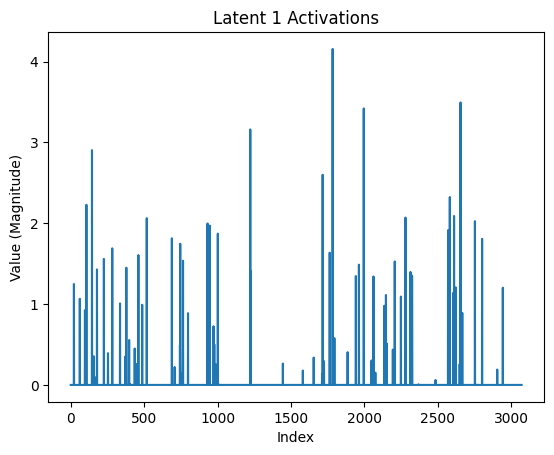

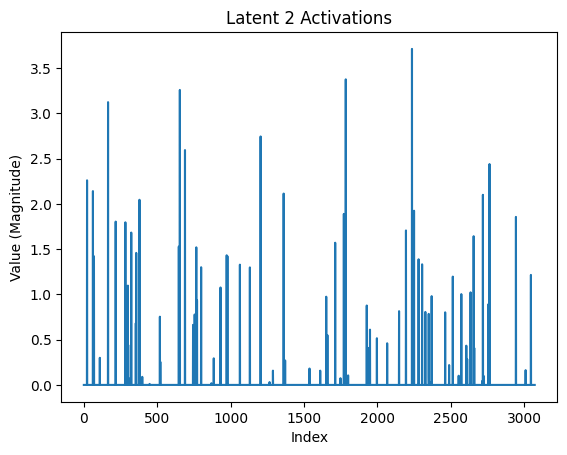

In [9]:
import torch
import matplotlib.pyplot as plt
loravec_1, latent_1, weights_1 = get_lora_dim(0)

# Convert tensor to numpy array
values = latent_1.squeeze().detach().cpu().numpy()
# Plot the data
plt.plot(values)
plt.xlabel('Index')
plt.ylabel('Value (Magnitude)')
plt.title('Latent 1 Activations')
plt.show()


loravec_2, latent_2, weights_2 = get_lora_dim(1)

# Convert tensor to numpy array
values = latent_2.squeeze().detach().cpu().numpy()
# Plot the data
plt.plot(values)
plt.xlabel('Index')
plt.ylabel('Value (Magnitude)')
plt.title('Latent 2 Activations')
plt.show()


### Test random dimming and pinning of sparse latent codes, first two images are non-adjusted, last 2 are adjusted

Lora Id: 128, pinned: tensor([1372, 1834,  105,  553], device='cuda:0'), dimmed: tensor([2241,  452], device='cuda:0')


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

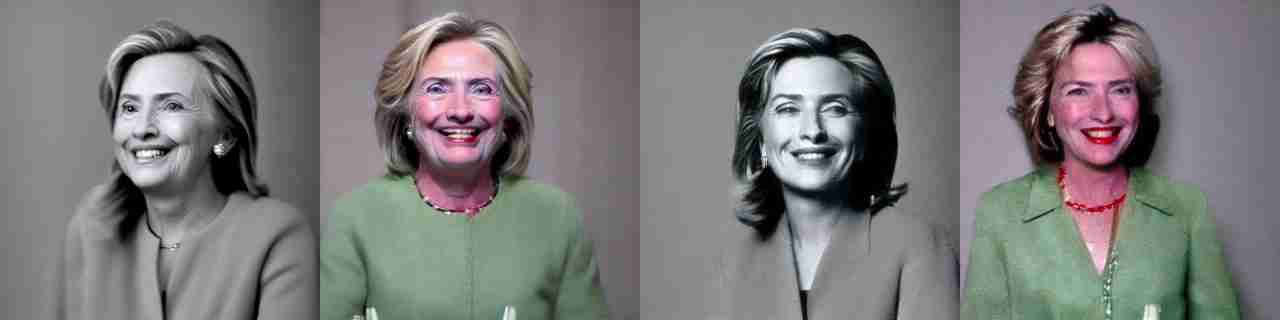

Lora Id: 13, pinned: tensor([2388, 2127, 1868, 1871], device='cuda:0'), dimmed: tensor([2860,  830], device='cuda:0')


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

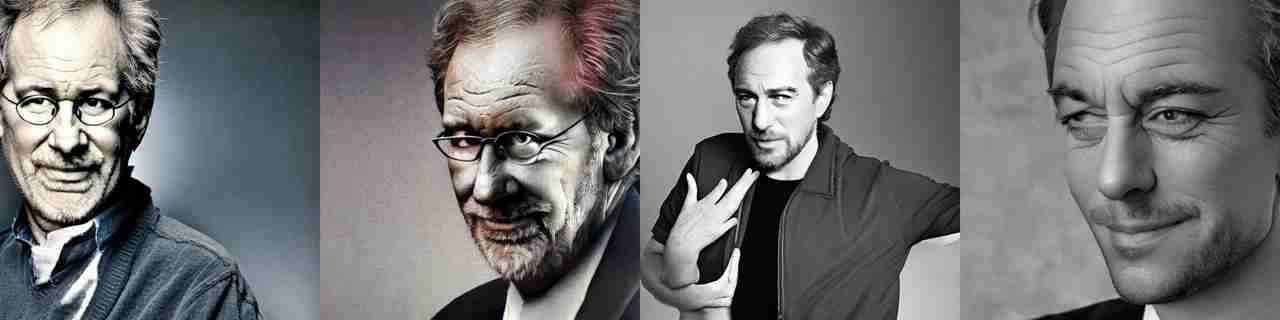

Lora Id: 32, pinned: tensor([ 915,  965, 1519, 1472], device='cuda:0'), dimmed: tensor([398, 689], device='cuda:0')


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

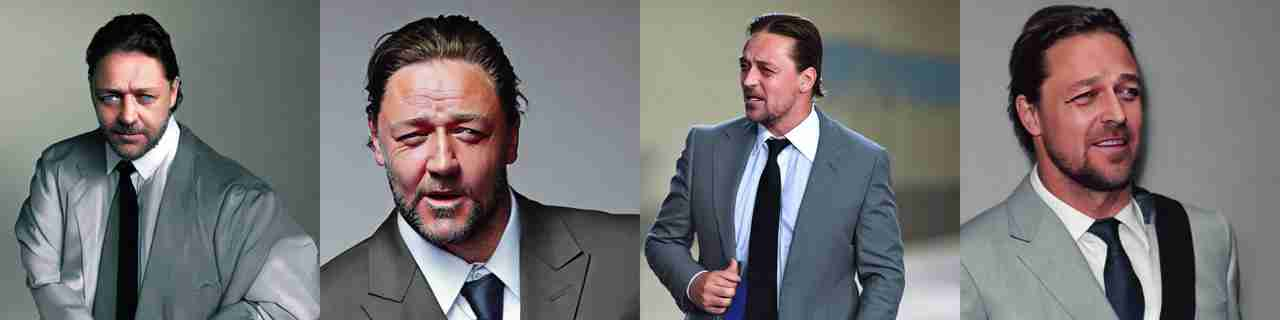

Lora Id: 56, pinned: tensor([1041, 2668, 1351, 2287], device='cuda:0'), dimmed: tensor([1754, 2207], device='cuda:0')


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

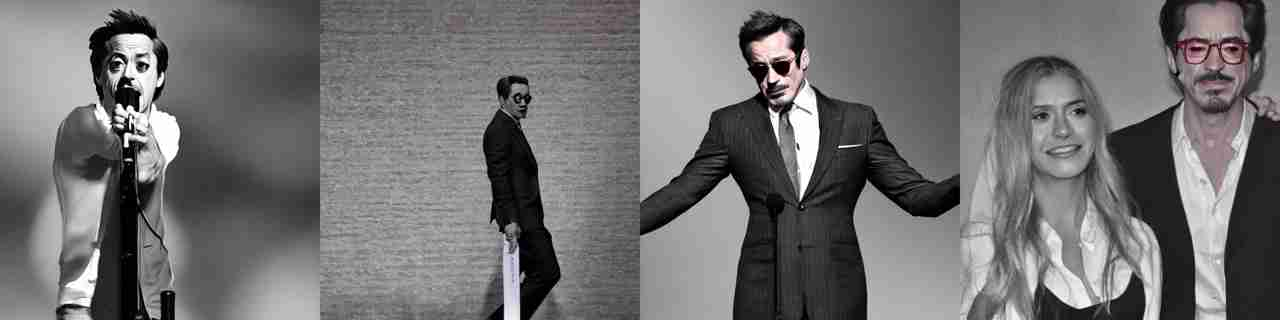

Lora Id: 123, pinned: tensor([ 847,  752, 1352, 2531], device='cuda:0'), dimmed: tensor([ 398, 1927], device='cuda:0')


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

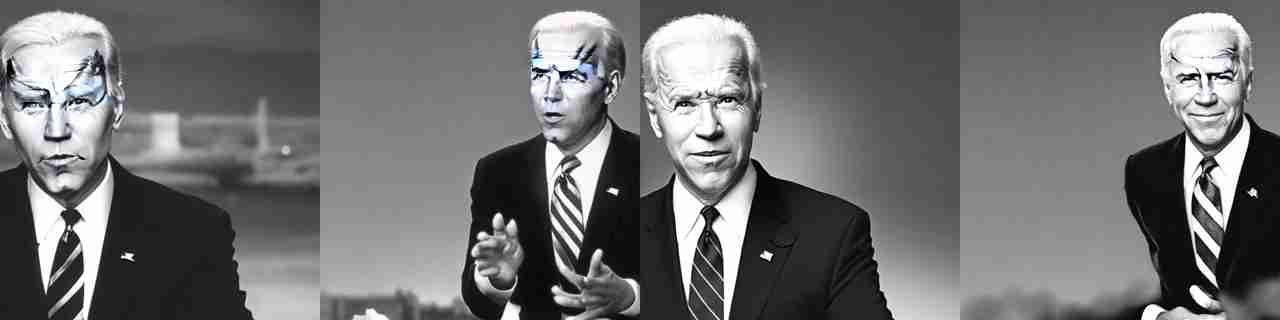

In [43]:
import random
with torch.no_grad():
    for i in range(5):
        #select random lora id from 0 to 136
        random_lora_id = random.randint(0, 135)
        _,latent, weight = get_lora_dim(random_lora_id)
        norm_lora_vec = get_lora_dim_from_latent(latent) 
        latent= latent.squeeze()
        # if latent has any value which is nan, then skip this iteration
        if torch.isnan(latent).any():
            continue
        # update 6 random values on the latent, 3 which were 0 turn to 4, 3 which were above 1 turn to 0, and print what was changed in 1 liner
        three_random_deactivated = torch.where(latent == 0)[0]
        # indicies random
        rand_indicies = torch.randperm(len(three_random_deactivated))[:4]

        three_random_deactivated = three_random_deactivated[rand_indicies]
        
        three_random_activated = torch.where(latent > 0)[0]
        rand_indicies = torch.randperm(len(three_random_activated))[:2]
        three_random_activated = three_random_activated[rand_indicies]

        
        latent[three_random_deactivated] = 4
        latent[three_random_activated] = 0
        lora_new_vec = get_lora_dim_from_latent(latent.unsqueeze(0)) 
        print(f"Lora Id: {random_lora_id}, pinned: {three_random_deactivated}, dimmed: {three_random_activated}")
        mutated_images = draw_from_loradim2(lora_new_vec, weight, pipe)
        normal_images = draw_from_loradim2(norm_lora_vec, weight, pipe)

        # both mutated_images and normal_images are list of images with 2 images each, merge them into 1 image each and display them side by side
        canvas = Image.new('RGB', (640*4, 640))
        
        
        for i, image in enumerate([*normal_images, *mutated_images]):
            canvas.paste(image, (640*i, 0))

        canvas = canvas.resize((640*2, 640//2))
        buffer = io.BytesIO()
        canvas.save(buffer, format="JPEG", quality=20)  
        buffer.seek(0)
        # Display the compressed image
        display(IPImage(data=buffer.getvalue()))

        



### Changing features of a LoRA by adjusting the sparse latent codes

  0%|          | 0/30 [00:00<?, ?it/s]

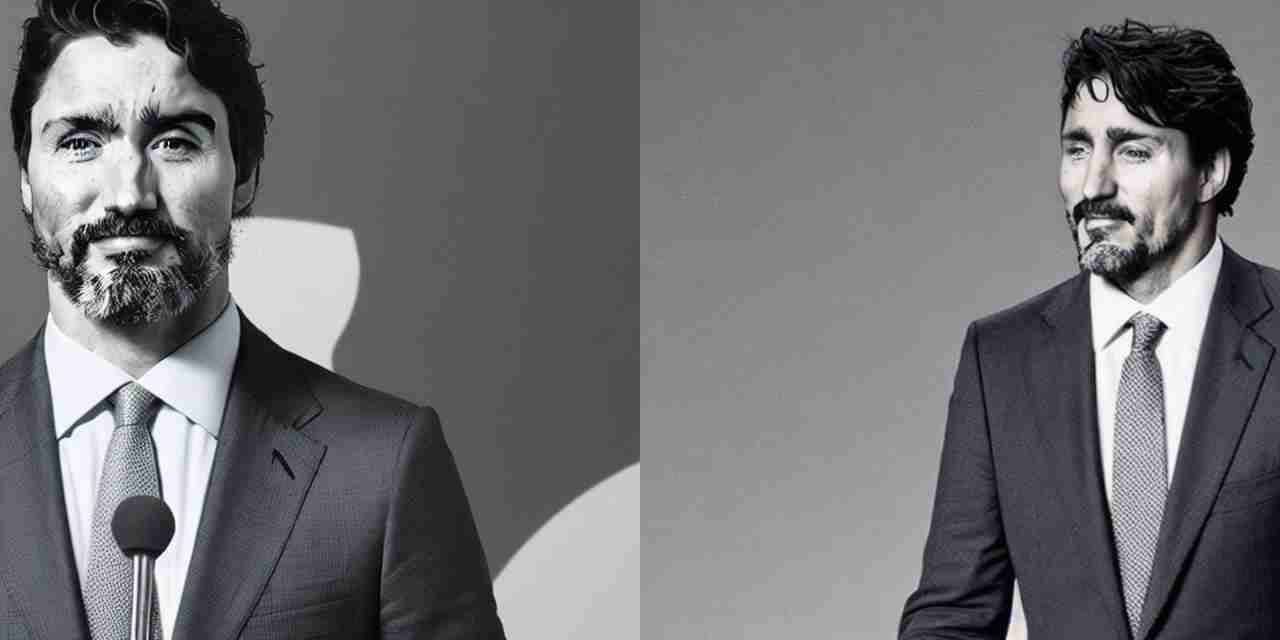

In [31]:
loravec_trudeu, latent_trudeu, weights_trudeu = get_lora_dim(0)

lora_new_vec = get_lora_dim_from_latent(latent_trudeu)
draw_from_loradim(lora_new_vec, weights_trudeu, pipe)

  0%|          | 0/30 [00:00<?, ?it/s]

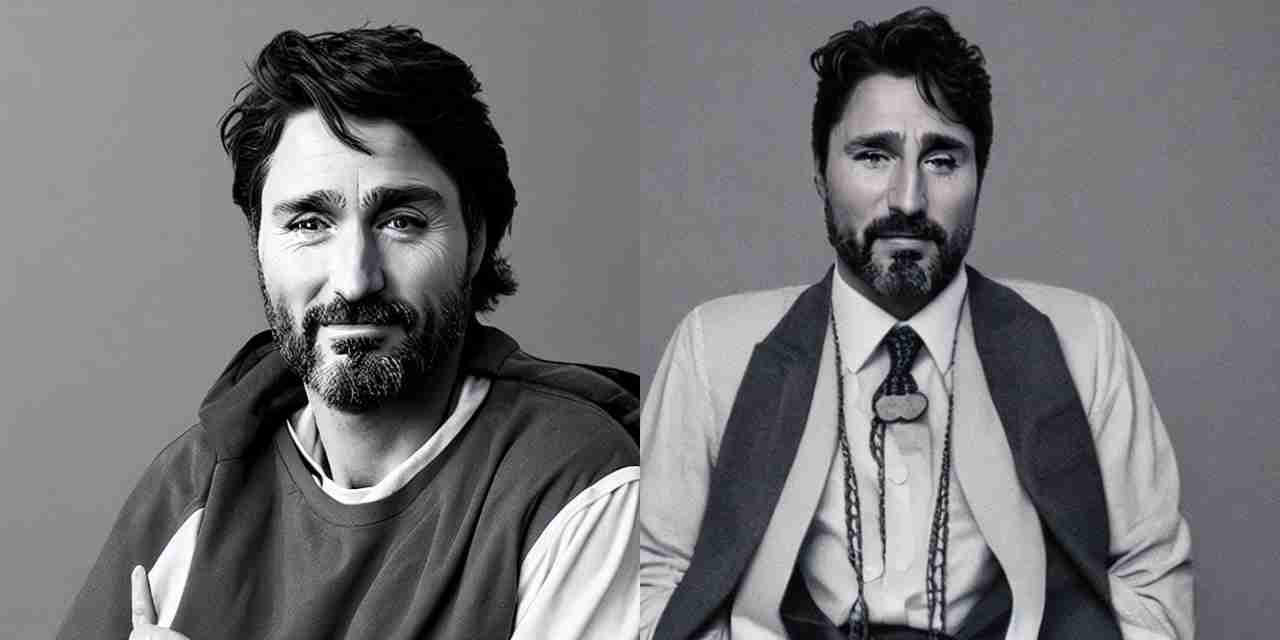

In [35]:
loravec_trudeu, latent_trudeu, weights_trudeu = get_lora_dim(0)
to_dim_indices = [398, 744] 
to_pin_indices = [914, 965, 1517]

latent_trudeu[0, to_dim_indices] = 0.0
latent_trudeu[0, to_pin_indices] = 4.0

lora_new_vec = get_lora_dim_from_latent(latent_trudeu)
draw_from_loradim(lora_new_vec, weights_trudeu, pipe)

### Merging two LoRAs by averaging their sparse latent codes

  0%|          | 0/30 [00:00<?, ?it/s]

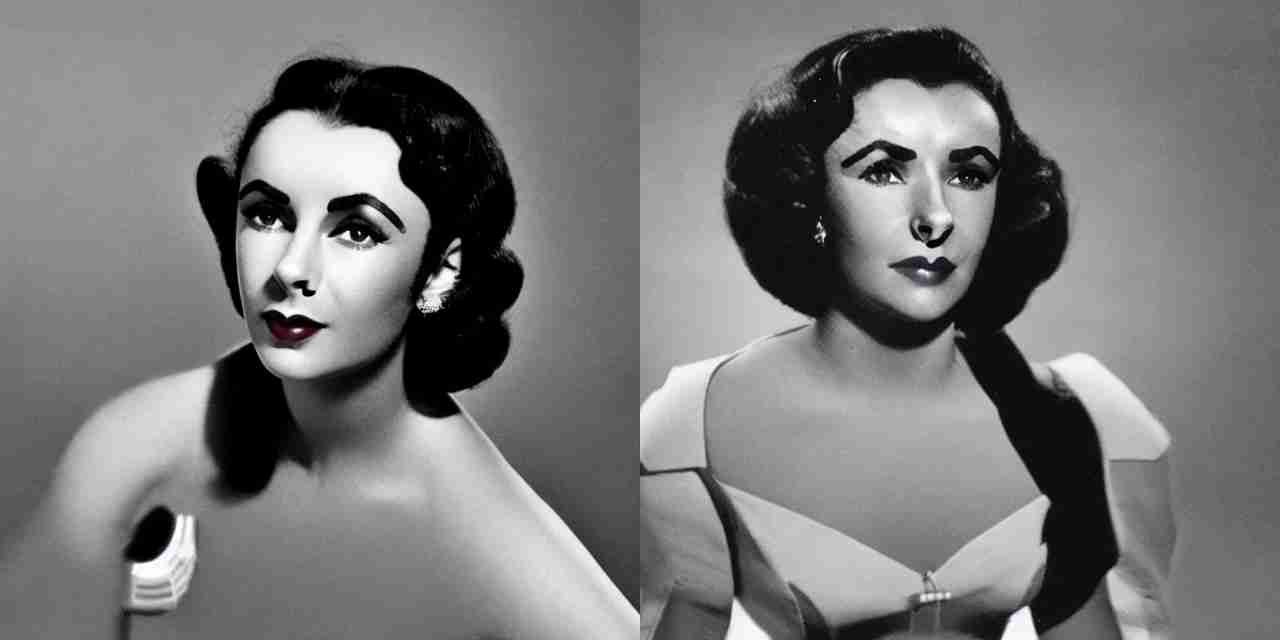

In [38]:
loravec_taylor, latent_taylor, weights_taylor = get_lora_dim(9)
loravec_trudeu, latent_trudeu, weights_trudeu = get_lora_dim(0)

lora_new_vec = get_lora_dim_from_latent(latent_taylor)
draw_from_loradim(lora_new_vec, weights_taylor, pipe)

  0%|          | 0/30 [00:00<?, ?it/s]

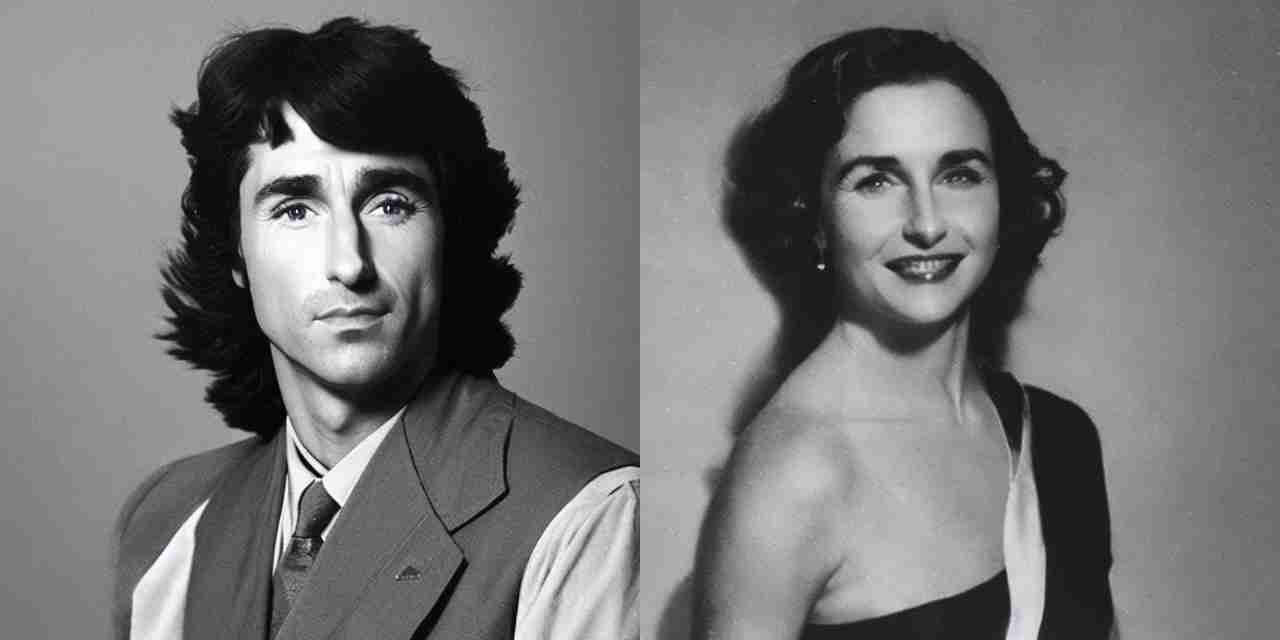

In [39]:
lora_new_vec = get_lora_dim_from_latent(((latent_trudeu + latent_taylor)/2))
draw_from_loradim(lora_new_vec, weights_trudeu, pipe)

  0%|          | 0/30 [00:00<?, ?it/s]

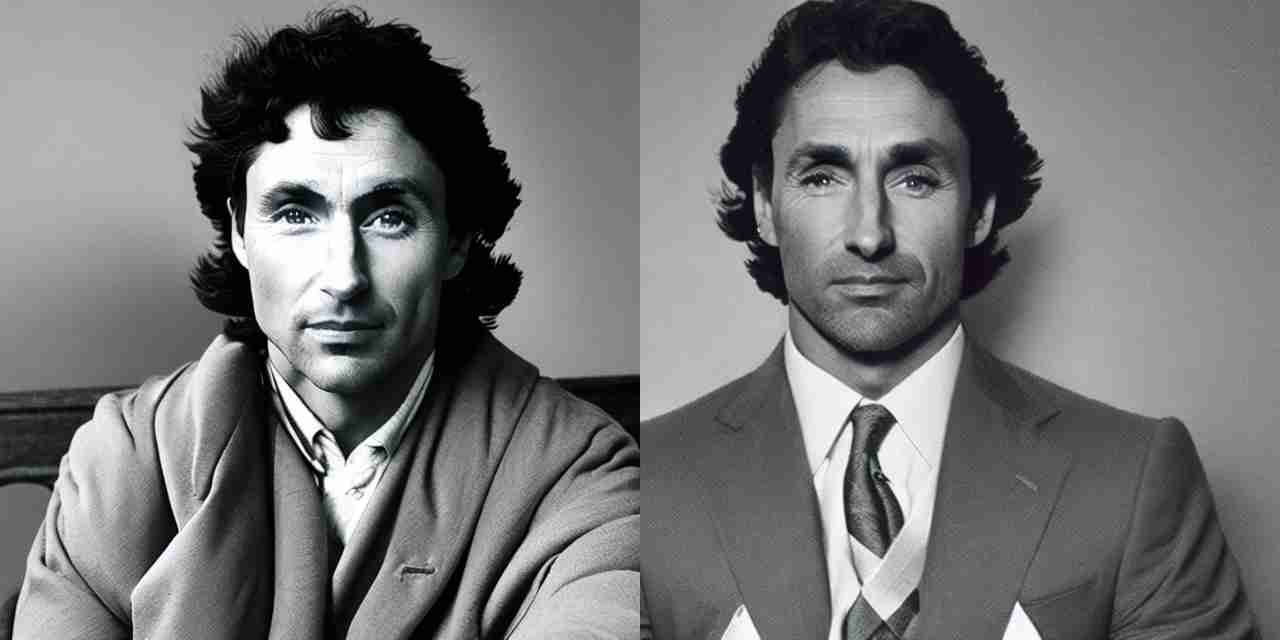

In [40]:
lora_new_vec = get_lora_dim_from_latent(torch.relu(latent_trudeu + latent_taylor))
draw_from_loradim(lora_new_vec, weights_trudeu, pipe)

  0%|          | 0/30 [00:00<?, ?it/s]

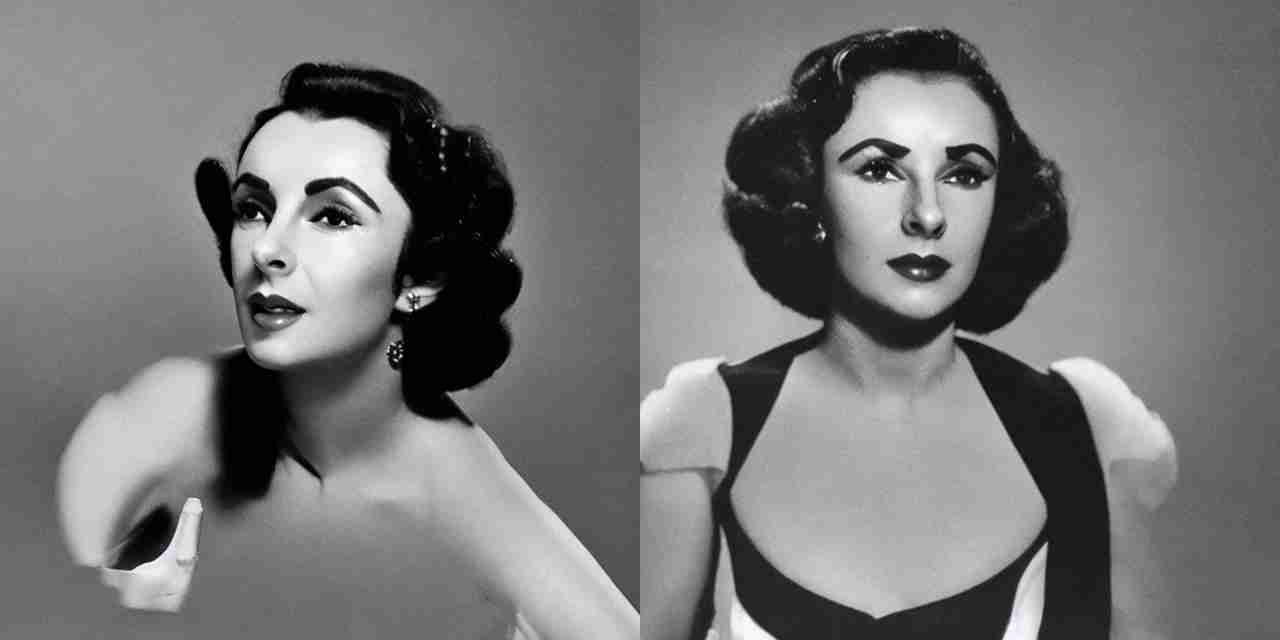

In [41]:
lora_new_vec = get_lora_dim_from_latent(torch.relu(latent_taylor - latent_trudeu ))
draw_from_loradim(lora_new_vec, weights_trudeu, pipe)